# CPSC 330 Lecture 2

# Lecture outline

- Cilantro dataset (5 min)
- Decision trees (30 min)
- Break (5 min)
- True/False questions (15 min)
- Decision tree splitting rules (5 min)
- ML model parameters and hyperparameters (10 min)

In [48]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.dummy import DummyClassifier

import graphviz

from plot_classifier import plot_classifier

In [27]:
def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_,impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## Cilantro dataset (5 min)

Here's the dataset you generated last class!

In [22]:
df = pd.read_csv('data/330-students-cilantro.csv')
df.head()

,What percentage of days do you typically eat meat or fish?,What percentage grade do you expect to get in this course?,Do you like cilantro?
0,42.0,90,Yes
1,85.0,83,No
2,28.0,83,Yes
3,100.0,80,No
4,100.0,75,No


In [38]:
df.describe()

,What percentage of days do you typically eat meat or fish?,What percentage grade do you expect to get in this course?
count,200.000000,200.000000
mean,72.812850,83.440000
std,31.605226,8.633603
min,0.000000,4.000000
25%,50.000000,80.000000
50%,86.000000,85.000000
75%,100.000000,90.000000
max,100.000000,100.000000


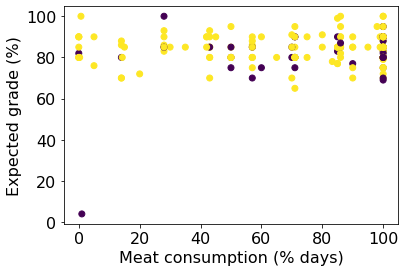

In [86]:
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=df.iloc[:,-1]=="Yes");
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

In [39]:
df["Do you like cilantro?"].value_counts()

Yes    144
No      56
Name: Do you like cilantro?, dtype: int64

In [23]:
X = df.iloc[:,:2]
X.head()

,What percentage of days do you typically eat meat or fish?,What percentage grade do you expect to get in this course?
0,42.0,90
1,85.0,83
2,28.0,83
3,100.0,80
4,100.0,75


In [24]:
y = df.iloc[:,-1]
y.head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: Do you like cilantro?, dtype: object

In [49]:
dc = DummyClassifier(strategy="prior")

In [51]:
dc.fit(X, y)
dc.score(X, y)

0.72

## Decision trees (20 min)

- Basic idea: ask a bunch of yes/no questions until you end up at a prediction.
- E.g. for our cilantro dataset,
  - If you eat meat < 5% of the time, predict "Yes"
  - Otherwise, if you eat meat > 95% of the time, predict "No"
  - Otherwise, if you expect to fail the course, predict "No"
  - Otherwise, predict "Yes"

- This "series of questions" approach can be drawn as a tree:

```
            Eats meat <5% of the time
            /          \
           / True       \  False
          /              \
         Yes           Eats meat >95% of the time
                        /      \
                  True /        \ False
                      /          \ 
                    No         Expects to fail the course (<50%)
                                 /           \
                                / True        \ False
                               /               \
                              No              Yes
```

- The decision tree algorithm automatically learns a tree like this, based on the data set!
  - We don't have time to go through how the algorithm works.
  - But it's worth noting that it support two types of inputs:

1. Categorical (e.g., Yes/No or more options)
2. Numeric (a number)

In the numeric case, the decision tree algorithm also picks the _threshold_ (e.g. 5%, 50%, etc.)

In our case here, both features are numeric.

Let's apply a decision tree to our cilantro dataset.

In [41]:
tree1 = DecisionTreeClassifier(max_depth=1).fit(X, y)

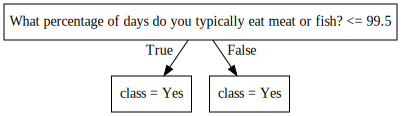

In [43]:
display_tree(df.columns[:-1], tree1)

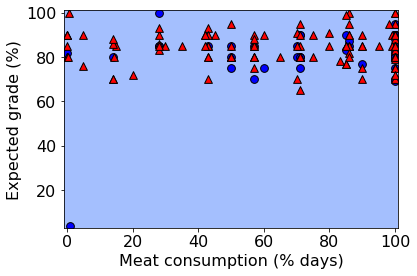

In [80]:
plot_classifier(X, y, tree1, ticks=True);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

- This is a totally useless decision tree that predicts "Yes" for any feature.
- This happens sometimes. Let's make the tree deeper by increasing `max_depth`.

In [44]:
tree2 = DecisionTreeClassifier(max_depth=2).fit(X, y)

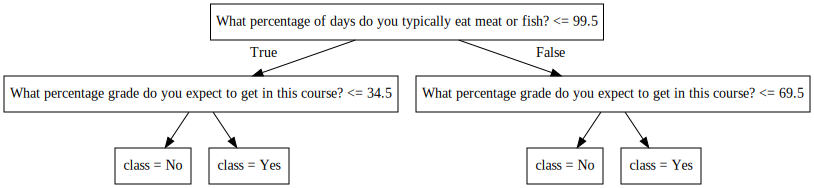

In [45]:
display_tree(df.columns[:-1], tree2)

In [46]:
tree2.score(X, y)

0.73

Moving on to `max_depth=100`...

In [59]:
tree100 = DecisionTreeClassifier(max_depth=100).fit(X, y)

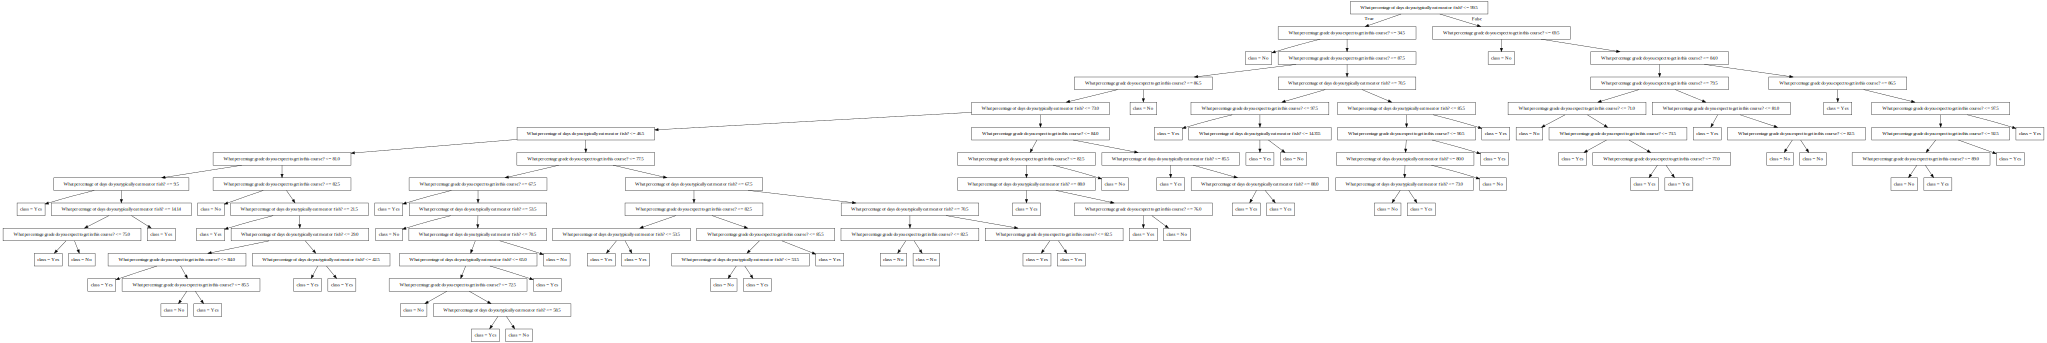

In [60]:
display_tree(df.columns[:-1], tree100)

In [61]:
tree100.score(X, y)

0.805

The reason it's not getting 100% accuracy: instances of duplicated features

In [77]:
df.loc[df.duplicated(subset=df.columns[:-1], keep=False)].sort_values(by=df.columns.values.tolist()).head(20)

,What percentage of days do you typically eat meat or fish?,What percentage grade do you expect to get in this course?,Do you like cilantro?
19,0.0,80,Yes
62,0.0,80,Yes
100,0.0,80,Yes
143,0.0,90,Yes
170,0.0,90,Yes
198,0.0,90,Yes
69,14.0,70,Yes
130,14.0,70,Yes
31,28.0,85,No
162,28.0,85,No


### Using scikit-learn's fit/predict

In [10]:
model = DecisionTreeClassifier(max_depth=1)
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [11]:
type(model)

sklearn.tree.tree.DecisionTreeClassifier

We'll pick a few examples at random just for a toy example.

In [12]:
df = pd.read_csv('data/cities_USA.csv', index_col=0).sample(6, random_state=100)
df

,lon,lat,vote
249,-124.027305,40.822381,blue
319,-110.941976,42.712829,red
174,-84.569611,39.032378,red
286,-95.340293,41.827063,blue
185,-77.316731,39.210042,blue
236,-100.310773,40.578560,red


In [13]:
X = df.drop(columns=['vote'])
y = df[['vote']]

In [14]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
df

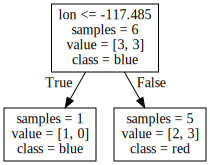

In [15]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["blue", "red"],
                                impurity=False))

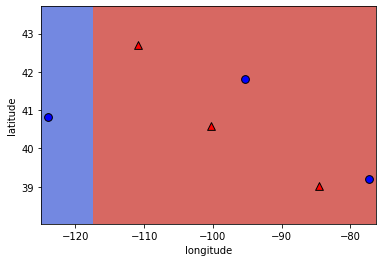

In [16]:
plt.figure()
ax = plt.gca()
plot_classifier(X, y, model, ax=ax, ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [17]:
model.score(X, y)

0.6666666666666666

In [18]:
y

,vote
249,blue
319,red
174,red
286,blue
185,blue
236,red


In [19]:
model.predict(X)

array(['blue', 'red', 'red', 'red', 'red', 'red'], dtype=object)

- we can also predict a brand new (made up) point

In [20]:
X

,lon,lat
249,-124.027305,40.822381
319,-110.941976,42.712829
174,-84.569611,39.032378
286,-95.340293,41.827063
185,-77.316731,39.210042
236,-100.310773,40.578560


In [23]:
made_up_X = np.array([-85, 30])


In [24]:
made_up_X.shape

(2,)

In [26]:
made_up_X = made_up_X[np.newaxis]

In [27]:
made_up_X.shape

(1, 2)

In [28]:
model.predict(made_up_X)

array(['red'], dtype=object)

In [ ]:
model.fit(X, y)

Let's look at a deeper tree now, on the full data set.

In [29]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]

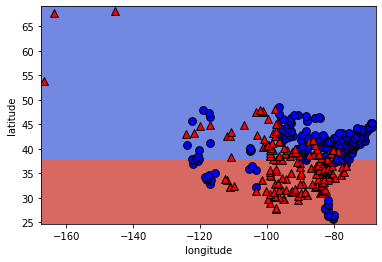

In [30]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X,y)

plt.figure()
ax = plt.gca()
plot_classifier(X, y, model, ax=ax, ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [31]:
model.score(X,y)

0.7475

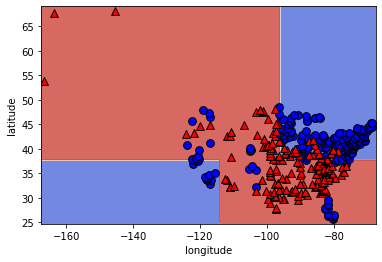

In [36]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X,y)
plt.figure()
ax = plt.gca()
plot_classifier(X, y, model, ax=ax, ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

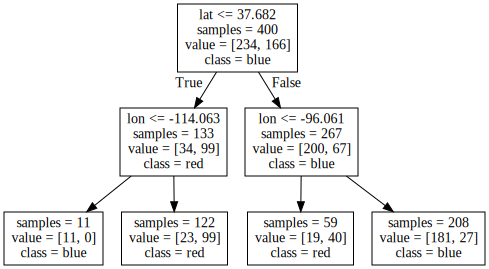

In [33]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["blue", "red"],
                                impurity=False))

In [37]:
model.score(X,y)

0.8275

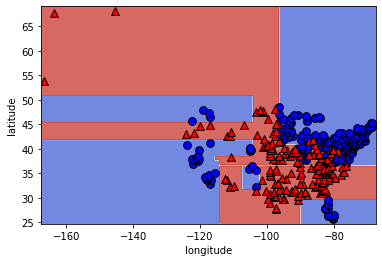

In [38]:
model = DecisionTreeClassifier()
model.fit(X,y)
plt.figure()
ax = plt.gca()
plot_classifier(X, y, model, ax=ax, ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [39]:
# dot_data = export_graphviz(model)
# graphviz.Source(export_graphviz(model,
#                                 out_file=None,
#                                 feature_names=X.columns,
#                                 class_names=["blue", "red"],
#                                 impurity=False))

In [40]:
model.score(X,y)

1.0

## Break (5 mins)

## Decision tree splitting rules (5 mins)

- You saw in the video that a tree with only one split is called a "decision stump"
- How do we decide how to split the data?
- Basic idea is to pick a criterion (see [here](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)) and then maximize it across possible splits.
- It turns out accuracy is not a good metric, so we use some fancier metrics like "entropy" or "gini impurity".
- The basic idea is to try and make each leaf as "pure" as possible.

##  ML model parameters and hyperparameters (10 mins)

- When you call `fit`, a bunch of values get set, like the split variables and split thresholds. 
- These are called **parameters**
- But even before calling `fit` on a specific data set, we can set some "knobs" that control the learning.
- These are called **hyperparameters**

In [42]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
df

,lon,lat,vote
1,-80.162475,25.692104,blue
2,-80.214360,25.944083,blue
3,-80.094133,26.234314,blue
4,-80.248086,26.291902,blue
...,...,...,...
397,-96.551116,48.591592,blue
398,-166.519855,53.887114,red
399,-163.733617,67.665859,red
400,-145.423115,68.077395,red


In scikit-learn, hyperparameters are set in the constructor:

In [44]:
model = DecisionTreeClassifier(max_depth=3) 
model.fit(X, y);

Here, `max_depth` is a hyperparameter. There are many, many more! See [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).



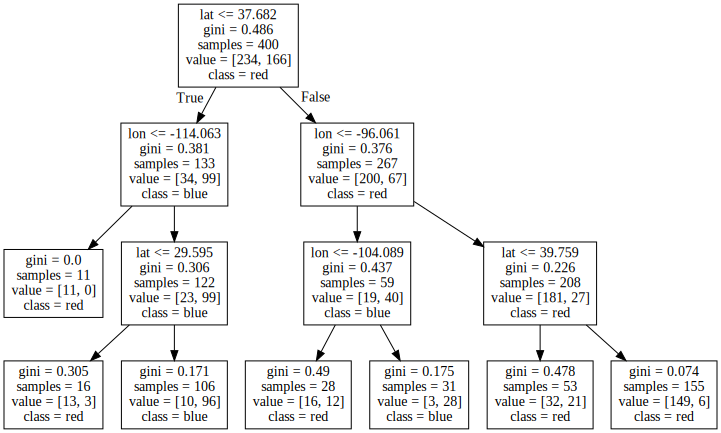

In [45]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["red", "blue"],
                                impurity=True))

To summarize:

- **parameters** are automatically learned by the algorithm during training
- **hyperparameters** are specified based on:
    - expert knowledge
    - heuristics, or 
    - systematic/automated optimization (more on that later on)

## Preview of next class...

- Why not just use a very deep decision tree for every supervised learning problem and get super high accuracy?

## True/False questions (25 min)

Which of these are true about decision trees?

1. Decision trees are typically binary trees (2 children per node).
2. Typically, the features that we split on at each node are chosen by a human.
3. A decision stump is defined as a decision tree with depth $\leq 3$.
5. The same feature can be split on multiple times in a tree with depth > 1.

<br><br><br><br><br><br>

For each of the following, answer with `fit` or `predict`:

1. At least for decision trees, this is where most of the hard work is done.
2. Only takes `X` as an argument.
3. In scikit-learn, we can ignore its output.
4. Is called first (before the other one).